In [ ]:
from hossam import *

from pandas import DataFrame, read_excel
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np
import statsmodels as sm
from itertools import combinations

from scipy.stats import pearsonr, spearmanr

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [ ]:
origin = load_data("fish")
origin.head()

농어의 길이,높이,두께,무게를 조사한 데이터 셋


,길이,높이,두께,무게
0,8.4,2.11,1.41,5.9
1,13.7,3.53,2.00,32.0
2,15.0,3.82,2.43,40.0
3,16.2,4.59,2.63,51.5
4,17.4,4.59,2.94,70.0


In [ ]:
df = origin

desc =df.describe().T

desc["missing"] = df.isnull().sum()

Q1=df.quantile(0.25)
Q3=df.quantile(0.75)
IQR = Q3-Q1
lower_bound = Q1 - 1.5 *IQR
upper_bound = Q3+1.5*IQR
outlier_count = ((df<lower_bound) | (df>upper_bound)).sum()
outlier_ratio = outlier_count/len(df) *100
desc["outlier_count"] = outlier_count
desc["outlier_ratio(%)"] = outlier_ratio

#숫자형 칼럼 이름만 추출
num_cols = df.select_dtypes(include=np.number).columns

#왜도 확인 및 로그 변환 필요성
for column in num_cols:
    skewness = df[column].skew()
    if abs(skewness)<0.5:
        strength = "week"
        log_transform ="not needed"

    elif abs(skewness)<1:
        strength = "normal"
        log_transform = "recommended"
    else:
        strength = "strong"
        log_transform = "needed"

    desc.loc[column, "skewness" ] = skewness
    desc.loc[column, "skewness_strength"] = strength
    desc.loc[column, "log_transform"] = log_transform

desc

,count,mean,std,min,25%,50%,75%,max,missing,outlier_count,outlier_ratio(%),skewness,skewness_strength,log_transform
길이,56.0,27.892857,9.021668,8.40,21.825,25.300,36.625,44.00,0,0,0.0,0.270547,week,not needed
높이,56.0,7.862143,2.878343,2.11,5.690,6.920,10.850,12.80,0,0,0.0,0.361355,week,not needed
두께,56.0,4.745536,1.775006,1.41,3.520,4.155,6.450,8.14,0,0,0.0,0.424951,week,not needed
무게,56.0,382.239286,347.617717,5.90,120.000,207.500,692.500,1100.00,0,0,0.0,0.844368,normal,recommended


In [ ]:
df1 = origin.copy()
df1["무게"] = np.log1p(df1["무게"])
df1.head()

,길이,높이,두께,무게
0,8.4,2.11,1.41,1.931521
1,13.7,3.53,2.00,3.496508
2,15.0,3.82,2.43,3.713572
3,16.2,4.59,2.63,3.960813
4,17.4,4.59,2.94,4.262680


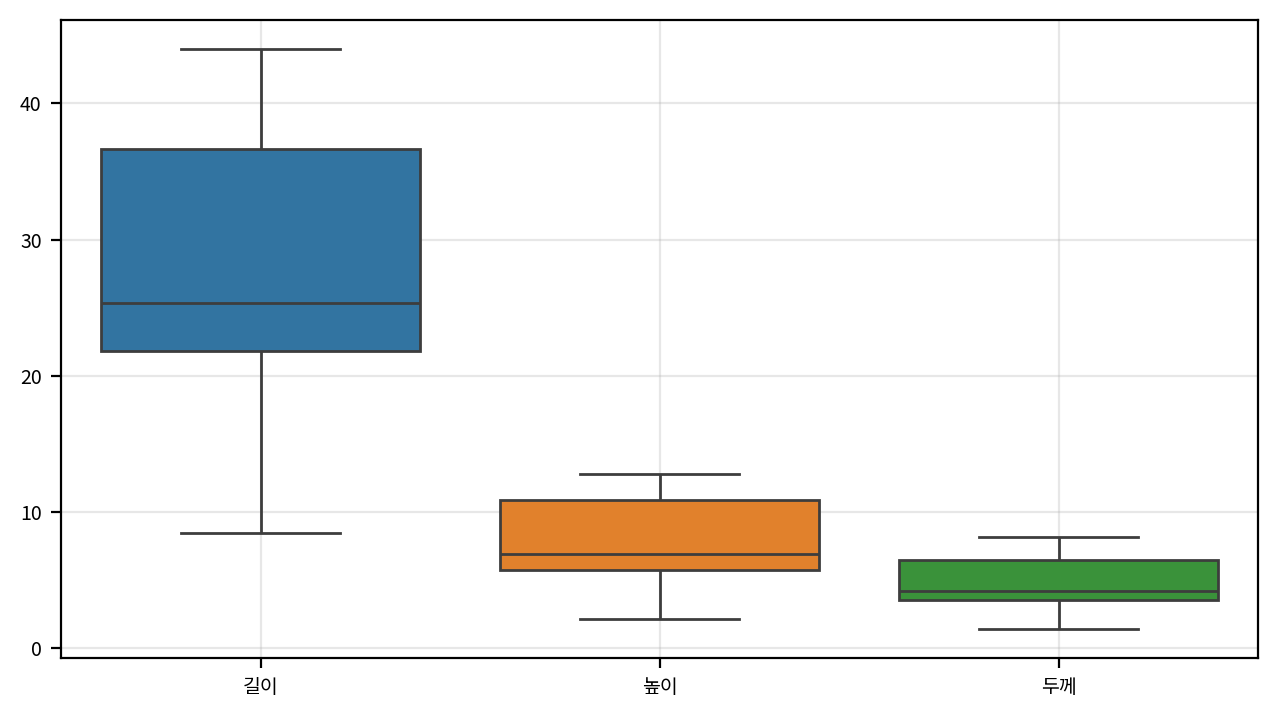

In [ ]:
figsize = (1280/ my_dpi, 720/my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

sb.boxplot(data= df1[["길이", "높이", "두께"]])
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

In [ ]:
df= df1[["길이", "높이", "두께"]]
scaler = StandardScaler()
df2= DataFrame(scaler.fit_transform(df), columns=df.columns)
df2["무게"]=df1["무게"]
df2.head()

,길이,높이,두께,무게
0,-2.180225,-2.016507,-1.896175,1.931521
1,-1.587434,-1.518703,-1.560774,3.496508
2,-1.442032,-1.417039,-1.316328,3.713572
3,-1.307815,-1.147103,-1.202633,3.960813
4,-1.173599,-1.147103,-1.026405,4.262680


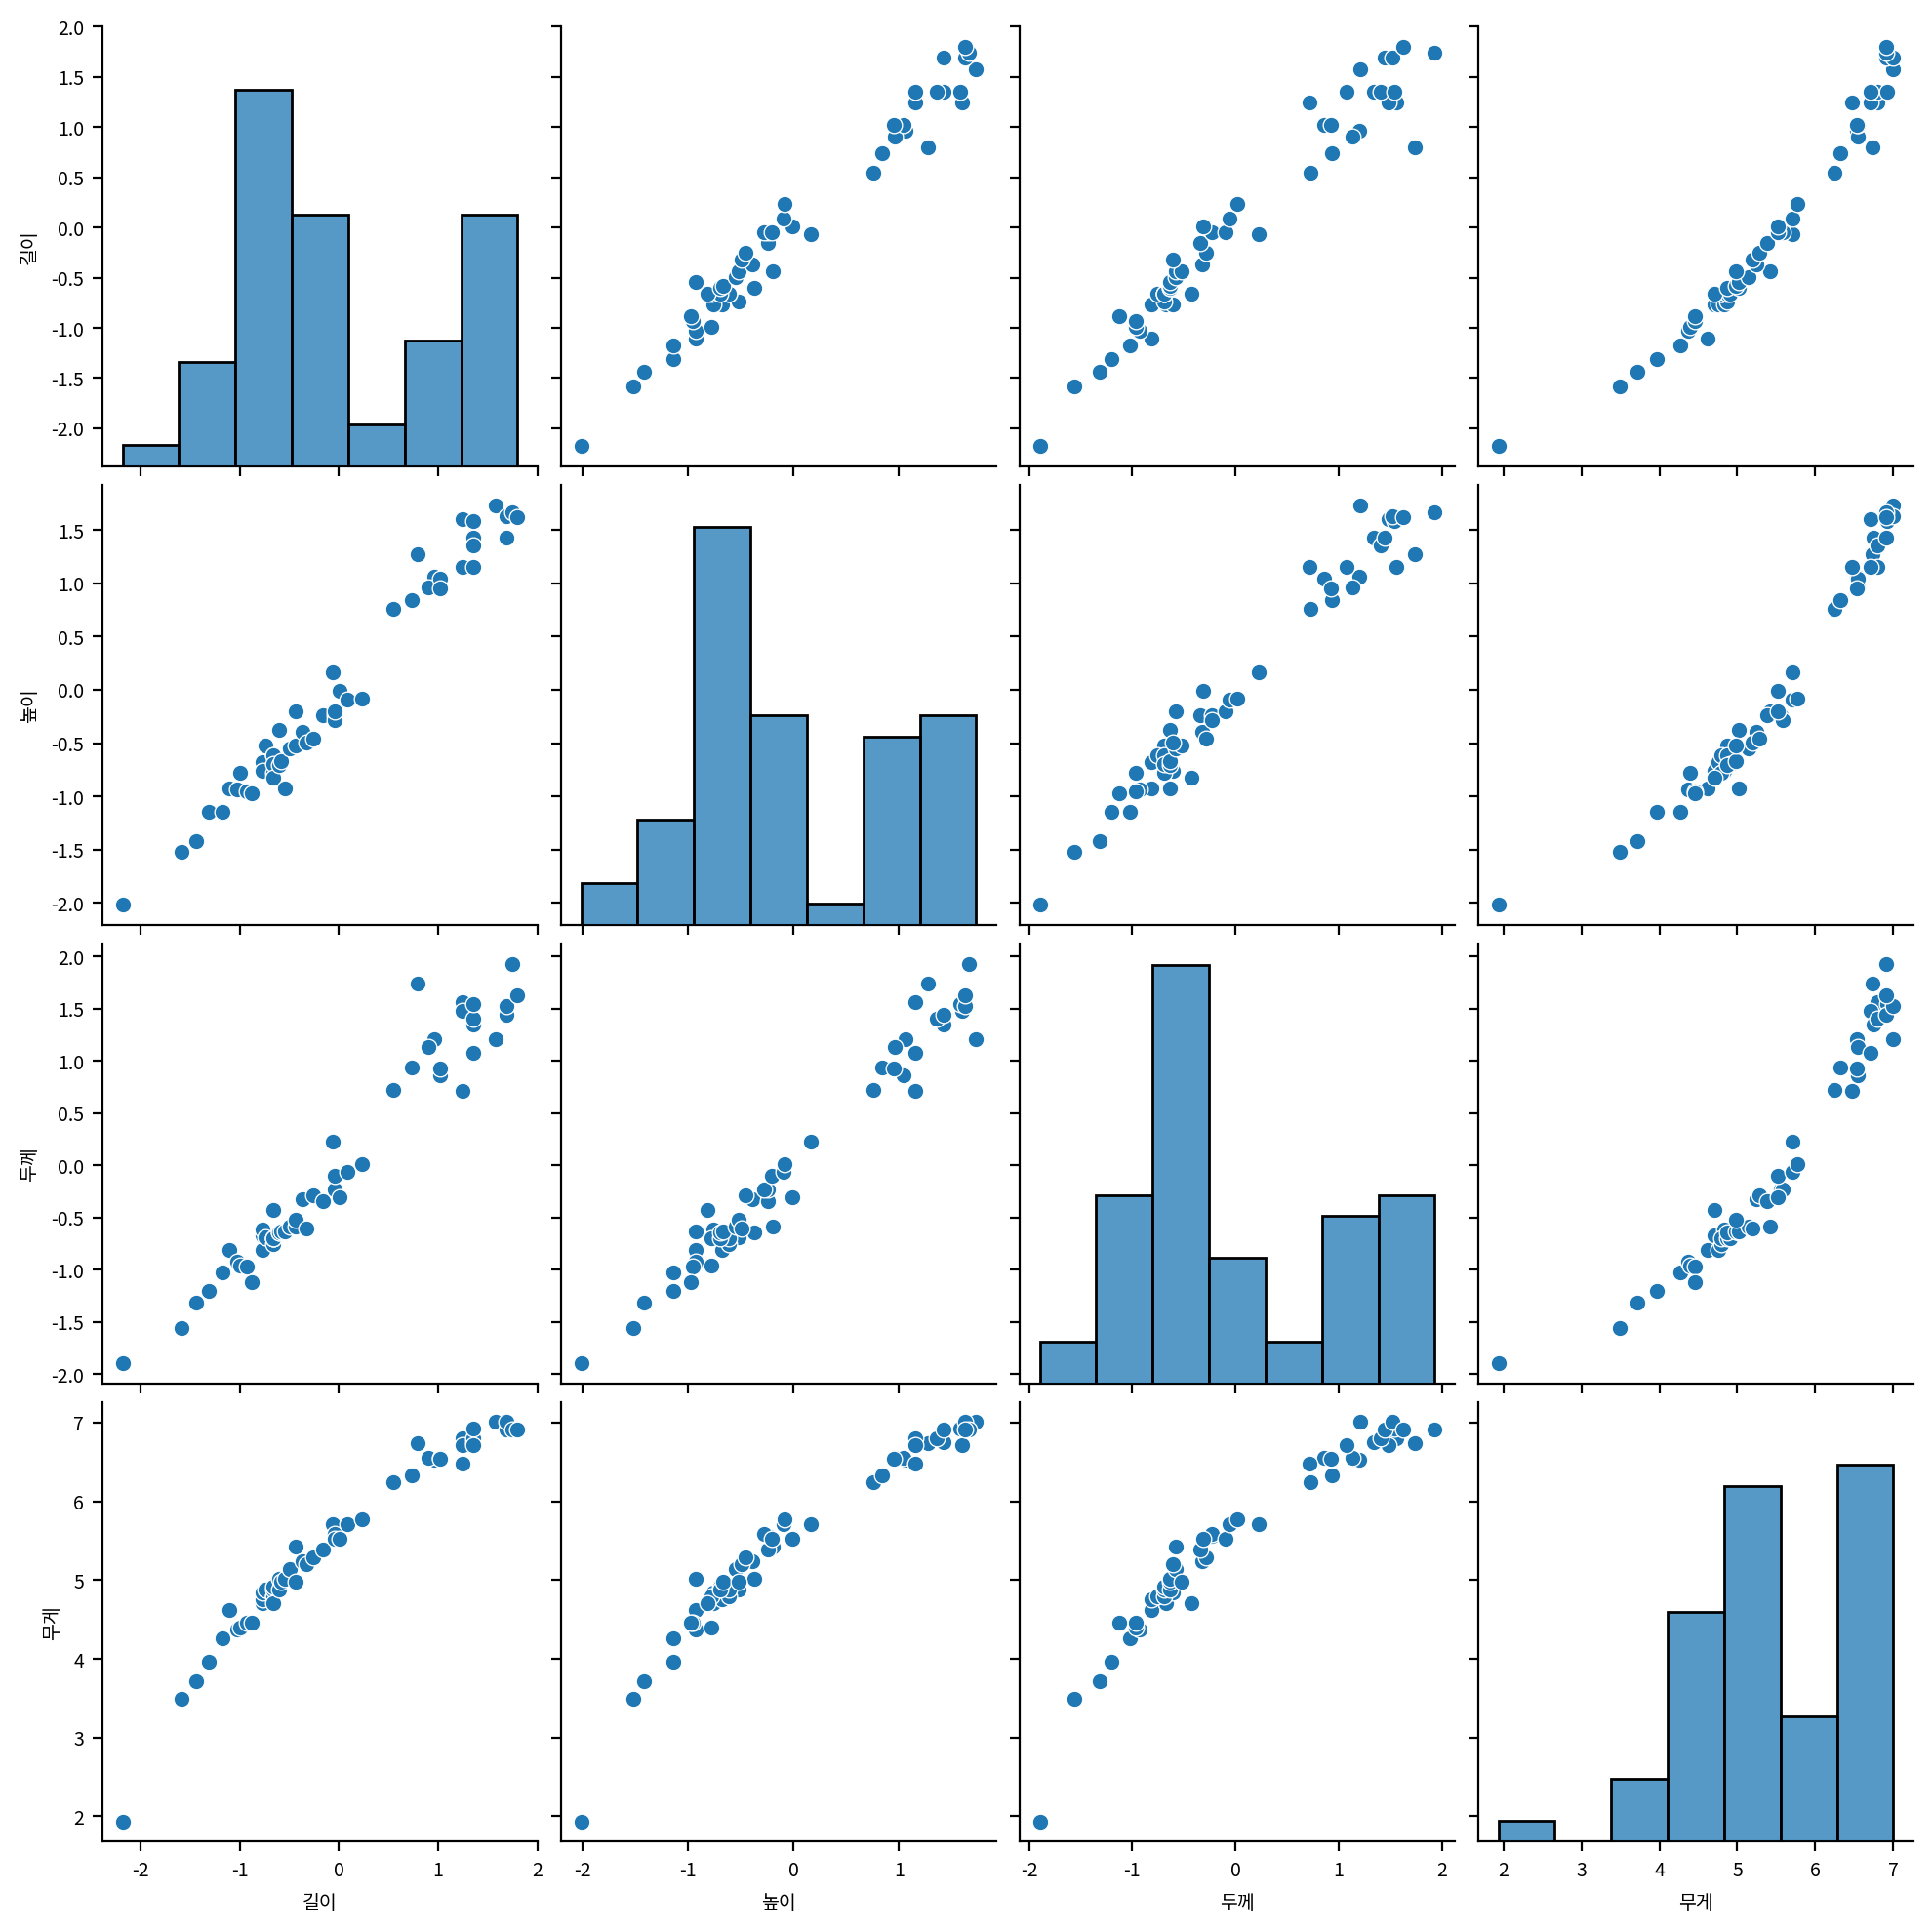

In [ ]:
sb.pairplot(df2)
plt.show()
plt.close()

In [ ]:
data = df2

z_thresh = 3.0

min_n =8

alpha =0.05

cols = data.select_dtypes(include=[np.number]).columns.tolist()

z_outlier_flags = {}

for c in cols:
    col = data[c].dropna()
    if col.std(ddof=1) == 0:
        z_outlier_flags[c] = False
        continue
    z = (col - col.mean()) /col.std(ddof=1)
    z_outlier_flags[c] = (z.abs()>z_thresh.any())

rows = []

for a,b in combinations(cols, 2):
    pair_df = data[[a,b]].dropna()
    if len(pair_df) <max(3, min_n):
        #표본이 너무 적으면 계산하지 않음
        rows.append(
            {
                "var_a":a,
                "var_b":b,
                "n":len(pair_df),
                "linearity":False,
                "outlier_flag" :True,
                "chosen":None,
                "corr":np.nan,
                "pval":np.nan,
                "significant":False,
                "strength": "nocorrelation"

            }
        )
        continue
    x= pair_df[a]
    y=pair_df[b]

    if x.nunique(dropna=True) <=1 or y.nunique(dropna=True)<=1:
        rows.append(
            {
                "var_a":a,
                "var_b":b,
                "n":len(pair_df),
                "linearity":False,
                "outlier_flag" :True,
                "chosen":None,
                "corr":np.nan,
                "pval":np.nan,
                "significant":False,
                "strength": "nocorrelation"
            }

        )   
        continue
    linearity_ok = False
    try:
        X_const = sm.add_constant(x)
        model = smOLS(y, Xconst).fit()
        pvals =[]
        for pwr in linearity_power:
            reset = linear_reset(model, power = pwr, use_f=True)
            pvals.append(reset.pvalue)
        #모든 차수에서 유의하지 않을 때 선형성 충족으로 간주
        if len(pvals) >0: 
            linearity_ok = all([pv> alpha for pv in pvals])
    except Exception:
        linearity_ok=False

    outlier_flag = bool(z_outlier_flags.get(a, False) or z_outlier_flags.get(b,False))

    try:
        if linearity_ok and not outlier_flag:
            chosen =""

result_df = DataFrame(rows)
result_df




TypeError: DataFrame.select_dtypes() got an unexpected keyword argument 'includes'. Did you mean 'include'?